# Лекция 7

## Часть 1. Итерационные методы и предобуславливатели
## Часть 2. Итерационные методы для поиска собственных значений

## На прошлой лекции

- Процесс Арнольди для ортогонализации Крыловского подпространства
- Процесс Ланцоша в симметричном случае
- Функционал энергии и метод сопряжённых градиентов
- Анализ сходимости
- Случай несимметричной системы: идея метода GMRES

## План на сегодня

### Часть 1
- Другие итерационные методы: MINRES, BiCG и BiCGStab 
- Концепция предобуславливателей

## Какой метод использовать?

- Если матрица симметричная (эрмитова) и положительно определённая, используйте метод сопряжённых градиентов.
- Если матрица симметричная, но не определённая, можем использовать метод MINRES (идея GMRES, применённая к симметричной системе, подробности далее)
- Если матрица несимметричная и не очень большая, используйте GMRES
- Если матрица несимметричная и мы можем хранить только ограниченное число векторов, используем либо GMRES с рестартами, либо BiCGStab (требуется также функция умножения на $A^{\top}$).

### Более детальный план по выбору метода из [этой книги](http://www.netlib.org/templates/templates.pdf)
<img src="./flowchart_iterative_methods.png">

## MINRES

Метод MINRES – это GMRES, применённый к симметричной матрице системы. Мы минимизируем

$$\Vert A Q_j x_j - f \Vert_2 = \Vert Q_j \widehat{x}_j + h_{j, j-1} q_j \widehat{x}_j - f \Vert_2 = \Vert Q_{j+1} \widehat{H}_{j+1}  \widehat{x}_j - f \Vert_2 \rightarrow \min$$

что эквивалентно линейной задаче наименьших квадратов с **почти трёхдиагональной** матрицей

$$\Vert \widehat{H}_{j+1} x_{j} - \gamma e_0 \Vert_2 \rightarrow \min.$$

- По аналогии с GMRES мы можем получить короткие рекуррентные соотношения

- Аккуратная реализация MINRES требует хранить не более $5$ векторов

## Отличия между MINRES и CG

- MINRES минимизирует $\Vert Ax_k - f \Vert_2$ на Крыловском подпространстве
- CG минимизирует $(Ax, x) - 2(f, x)$ на Крыловском подпространстве
- MINRES применим к неопределённым (то есть не положительно определённым) задачам.
- CG хранит меньше векторов ($3$ вместо $5$). 

Теперь перейдём к обсуждению несимметричных систем.

## Несимметричные системы

- Основной недостаток GMRES: нам нужно хранить все вектора, поэтому с каждой итерацией нужно всё больше и больше памяти

- Мы можем делать  **рестарты** (то есть вычислить новый вектор невязки и строить новое Крыловское подпространство на его основе): мы нашли некоторое приближённое решение $x$ и теперь решаем новую линейную систему на вектор коррекции:

$$A(x + e) = f, \quad Ae = f - Ax,$$

и генерируем новое **Крыловское подпространство** из данного вектора невязки. Это замедляет сходимость, что мы покажем далее.

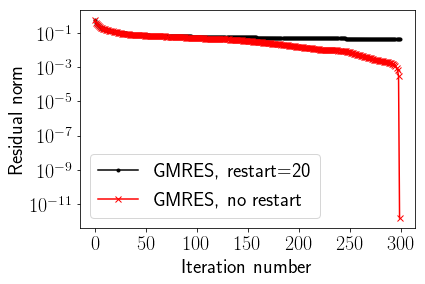

In [10]:
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
import numpy as np
import scipy as sp

n = 300
ex = np.ones(n);
A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(n)

res_gmres_rst = []
res_gmres = []
def gmres_rst_cl(r):
    res_gmres_rst.append(np.linalg.norm(r))
    
def gmres_rst(r):
    res_gmres.append(np.linalg.norm(r))

small_restart = 20
sol = scipy.sparse.linalg.gmres(A, rhs, restart=small_restart, callback=gmres_rst_cl)
sol = scipy.sparse.linalg.gmres(A, rhs, restart=n, callback=gmres_rst)

lim = 300
plt.semilogy(res_gmres_rst[:lim], marker='.',color='k', label='GMRES, restart={}'.format(small_restart))
plt.semilogy(res_gmres[:lim], marker='x',color='r', label='GMRES, no restart')
plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Residual norm', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

### Как избежать такого замедления сходимости?

- Метод бисопряжённых градиентов (biconjugate gradient method, название **BiCG** предложено Fletcher'ом, [оригинальная статья](https://link.springer.com/chapter/10.1007%2FBFb0080116)) позволяет избежать замедления сходимости с помощью "коротких рекуррентных соотношений" по аналогии с CG.

## Идея метода бисопряжённых градиентов

- Используем нормальное уравнение:

$$A^* A x = A^* f,$$

и применяем CG для его решения.

- Число обусловленности равно квадрату числа обусловленности для исходной матрицы, поэтому нам нужна процедура **стабилизации**.

- Стабилизация приводит к повышению устойчивости (подробности далее)

На следующем примере покажем неустойчивость метода бисопряжённывх градиентов для несимметричной матрицы.

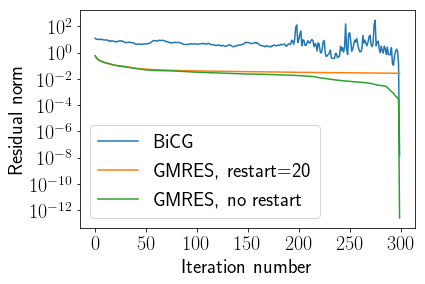

In [12]:
res_all_bicg = []
def bicg_cl(x):
    res_all_bicg.append(np.linalg.norm(A.dot(x) - rhs))
    
sol = scipy.sparse.linalg.bicg(A, rhs, x0=np.zeros(n), callback=bicg_cl)
plt.semilogy(res_all_bicg, label='BiCG')
plt.semilogy(res_gmres_rst[:n], label='GMRES, restart=20')
plt.semilogy(res_gmres, label='GMRES, no restart')
plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Residual norm', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

##  Бисопряжённые градиенты

У нас есть два варианта:

1. Использовать $\mathcal{K}(A^* A, A^* f)$ для генерации подпространства, но это приводит к увеличению числа обусловленности
2. Вместо этого можем использовать Крыловские подпространства $\mathcal{K}(A)$ и $\mathcal{K}(A^*)$ для генерации двух базисов, которые будут **биортогональны** (так называемый биортогональный процесс Ланцоша).

- Цель: вычислить проекцию Петрова-Галёркина исходной матрицы

$$W^* A V \widehat{x} = W^* f$$

со столбцами $W$ из Крыловского подпространства для матрицы $A^*$, и $V$ – для матрицы $A$ (сравните с CG). 

- Это может привести к неустойчивости, если мы будем пересчитывать решение наиболее эффективным образом.

## BiCG метод

На практике для реализации метода BiCG используют **двусторонний процесс Ланцоша**: генерирование Крыловского подпространства для $A$ и $A^{\top}$.

В частности,

1. $\alpha_j = \frac{(r_j, \hat{r}_j)}{(Ap_j, \hat{p}_j)}$
2. $x_{j+1} = x_j + \alpha_j p_j $
3. $r_{j+1} = r_j - \alpha_j Ap_j$
4. $\hat{r}_{j+1} = \hat{r}_j - \alpha_j A^{\top}\hat{p}_j$
5. $\beta_j = \frac{(r_{j+1}, \hat{r}_{j+1})}{(r_j, \hat{r}_j)}$
6. $p_{j+1} = r_{j+1} + \beta_j p_j$
7. $\hat{p}_{j+1} = \hat{r}_{j+1} - \beta_j \hat{p}_j$

Далее рассмотрим устойчивую версию метода BiCG.

## BiCGStab

- BiCGStab часто используется и представляет из себя **стабилизированную** версию методу BiCG. Он обладает более быстрой и гладкой сходимостью, чем оригинальный метод BiCG.

- Формулы можно посмотреть, например, [тут](https://en.wikipedia.org/wiki/Biconjugate_gradient_stabilized_method)

- Они являются комбинацией шага метода BiCG с последующим шагом GMRES(1) для сглаживания сходимости.

- Более подробно метод описан в книге ["Iterative Krylov Methods for Large Linear Systems"](http://www.lmn.pub.ro/~daniel/ElectromagneticModelingDoctoral/Books/Numerical%20Methods/VanDerVorst2003%20Iterative%20Krylov%20Methods%20for%20Large%20Linear%20Systems.pdf) за авторством H. Van-der Vorst.

Далее сравним сходимость стабилизированной и нестабилизированной версии метода BiCG

Dimension of the linear system = 90000


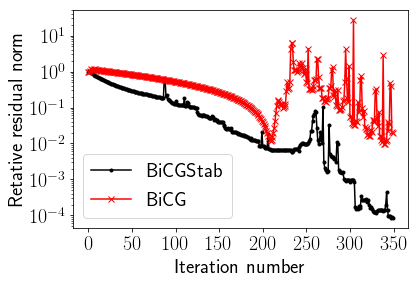

In [11]:
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

n = 300

# ex = np.ones(n);
# A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr') 
# rhs = np.random.randn(n)

ee = sp.sparse.eye(n)
A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr')
A = sp.sparse.kron(A, ee) + sp.sparse.kron(ee, A)
rhs = np.ones(n * n)

print("Dimension of the linear system = {}".format(A.shape[0]))

res_all_bicg = []
res_all_bicgstab = []
def bicg_cl(x):
    res_all_bicg.append(np.linalg.norm(A.dot(x) - rhs))

def bicgstab_cl(x):
    res_all_bicgstab.append(np.linalg.norm(A.dot(x) - rhs))

sol2 = scipy.sparse.linalg.bicg(A, rhs, x0=np.zeros(A.shape[0]), callback=bicg_cl)
sol2 = scipy.sparse.linalg.bicgstab(A, rhs, x0=np.zeros(A.shape[0]), callback=bicgstab_cl)
res_all_bicg = np.array(res_all_bicg)/res_all_bicg[0]
res_all_bicgstab = np.array(res_all_bicgstab)/res_all_bicgstab[0]

lim = 350
plt.semilogy(res_all_bicgstab[:lim], marker='.',color='k', label='BiCGStab')
plt.semilogy(res_all_bicg[:lim], marker='x',color='r', label='BiCG')

plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Retative residual norm', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

## "Нелинейный GMRES" или ускорение Андерсона

- Мы можем применить идею похожую на идею метода GMRES для ускорения сходимости произвольного метода неподвижной точки

$$x_{k+1} = \Phi(x_k).$$

- На самом деле такой подход был предложен задолго до метода GMRES, и известен в квантовой химии как "Direct Inversion in Iterated Subspaces", или **ускорение Андерсона**.

- Идея: **используем историю** для обновления

$$x_{k+1} = \Phi(x_k) + \sum_{s=1}^m \alpha_s (x_{k - s} - \Phi(x_{k - s})), $$

а параметры $\alpha_s$ выбираются так, чтобы минимизировать норму невязки

$$ \min_{\alpha} \left \| \sum_{s=1}^m \alpha_s (x_{k - s} - \Phi(x_{k - s})) \right\|_2, \quad \sum_{s=1}^m \alpha_s = 1$$

- Более подробно см. в [оригинальной работе](https://users.wpi.edu/~walker/Papers/Walker-Ni,SINUM,V49,1715-1735.pdf)

## Борьба с числом обусловленности

- Проблема большого числа обусловленности **непреодолима**, если доступна только процедура умножения матрицы на вектор.

- Поэтому для её решения нам нужны **предобуславливатели**.

- Существует несколько предобуславливателей, применимых для любой задачи, но часто для конкретной задачи нужен специально построенный предобуславливатель.

### Предобусловливатель: концепция

Дана линейная система 

$$A x = f,$$

мы хотим найти матрицу $P_R$ и/или $P_L$ такую что 

1. Число обусловленности $AP_R^{-1}$ (правый предобуславливатель) или $P^{-1}_LA$ (левый предобуславливатель) или $P^{-1}_L A P_R^{-1}$ меньше, чем у $A$
2. Мы можем быстро решать системы $P_Ly = g$ или $P_Ry = g$ для любых $g$ (иначе мы могли бы взять например $P_L = A$)

- Тогда мы решаем следующую систему (для правого предобуславливателя)

$$ AP_R^{-1} y = f \quad \Rightarrow \quad P_R x = y$$ 

или (для левого предобуславливателя)

$$ P_L^{-1} A x = P_L^{-1}f,$$ 

или для обоих 

$$ P_L^{-1} A P_R^{-1} y = P_L^{-1}f \quad \Rightarrow \quad P_R x = y.$$ 

- Лучший выбор, конечно, $P = A$, но он не делает жизнь проще (почему?)

- Одна из идей – это использовать другие итерационные меоды (помимо Крыловских) как предобуславливатели

### Другие итерационные методы как предобуславливатели

Существуют другие итерационные методы, которые мы ещё не упоминали. 

1. Метод Якоби
2. Метод Гаусса-Зейделя
3. SOR($\omega$) (Successive over-relaxation) и его симметричная модификация SSOR($\omega$)

### Метод Якоби (как предобуславливатель)

Рассмотрим матрицу с ненулевой диагональю. Для получения **метода Якоби** выразим диагональный элемент:

$$a_{ii} x_i = -\sum_{i \ne j} a_{ij} x_j + f_i$$

и используем это выражение для обновления $x_i$:

$$ x_i^{(k+1)} = -\frac{1}{a_{ii}}\left( \sum_{i \ne j} a_{ij} x_j^{(k)} + f_i \right),$$

или в матричной форме

$$ x^{(k+1)} = D^{-1}\left((D-A)x^{(k)} + f\right) $$

где $D = \mathrm{diag}(A)$ и наконец

$$ x^{(k+1)} = x^{(k)} - D^{-1}(Ax^{(k)} - f). $$

- Метод Якоби – это метод Ричардсона с $\tau=1$ и левым предобуславливателем $P = D$ – диагональной матрицей. 
- Поэтому мы будем называть $P = \mathrm{diag}(A)$ **предобуславливаталем Якоби**. 
- Отметим, что он может быть использован для других методов, например для метода Чебышёва или Крыловских методов.

### Свойства предобуславливателя Якоби

Предобуславливатель Якоби:

1. Очень прост для вычисления и использования
2. Хорошо работает для матриц с диагональным преобладанием (вспомните теорему о кругах Гершгорина!)
3. Бесполезен, если все диагональные элементы одинаковы (пропорционален единичной матрице)

### Метод Гаусса-Зейделя (как предобуславливатель)

- Другой хорошо известный метод – это **метод Гаусса-Зейделя**. 

- Его каноническая форма очень похожа на метод Якоби с одним небольшим отличием. Когда мы обновляем $x_i$

$$x_i^{(k+1)} := -\frac{1}{a_{ii}}\left( \sum_{j =1}^{i-1} a_{ij} x_j^{(k+1)} +\sum_{j = i+1}^n a_{ij} x_j^{(k)} - f_i \right)$$

мы **используем последние обновления предыдущих компонент**. В методе Якоби мы использовали весь вектор с прошлой итерации.

- Его матричная форма более сложная.

### Метод Гаусса-Зейделя: матричная форма

- Пусть дана матрица $A = A^{*} > 0$, для которой справедливо следующее представление  

$$A = L + D + L^{*},$$

где $D$ – диагональная часть матрицы $A$, $L$ – нижнетреугольная часть с нулями на диагонали.

- Одна итерация метода Гаусса-Зейделя записывается следующим образом

$$ x^{(k+1)} = x^{(k)} - (L + D)^{-1}(Ax^{(k)} - f) $$

и приводит нас к предобуславливателю $P = L+D$, который мы будем называть **предобуславливатель Гаусса-Зейделя**.

- **Хорошая новость:** $\rho(I - (L+D)^{-1} A) < 1, $ где $\rho$ – спектральный радиус, то есть для симметричной положительно определённой матрицы метод Гаусса-Зейделя сходится.

### Метод Гаусса-Зейделя и координатный спуск

- Метод Гаусса-Зейделя может быть рассмотрен как координатный спуск применённый к функционалу энергии

$$F(x) = (Ax, x) - 2(f, x).$$

- Одна итерация примет вид 

$$x_i := \arg \min_z F(x_1, \ldots, x_{i-1}, z, x_{i+1}, \ldots, x_d).$$

- Порядок исключения переменных очень важен!

## Successive overrelaxation (как предобуславливатель)

Далее добавим параметр $\omega$ в предобуславливатель Гаусса-Зейделя и получим метод **successive over-relaxation** (**SOR($\omega$)**):

$$ x^{(k+1)} = x^{(k)} - \omega (D + \omega L)^{-1}(Ax^{(k)} - f). $$

$$P = \frac{1}{\omega}(D+\omega L).$$

- Сходится для $0<\omega < 2$. 
- Оптимальный выбор $\omega$ – нетривиальная задача. Если метод Якоби сходится, то

$$\omega^* = \frac{2}{1 + \sqrt{1 - \rho_J^2}},$$ 

где $\rho_J$ – спектральный радиус в методе Якоби.
- Отметим, что $\omega = 1$ даёт предобуславливатель Гаусса-Зейделя.


### Предобуславливатели для разреженных матриц

- Если $A$ разрежена, то стоимость одной итерации метода Якоби, Гаусса-Зейделя и SOR низкая (какая сложность?). 

- В методе Гаусса-Зейделя нам нужно решить систему лийненых уравнений с треугольной матрицей $L$, что стоит $\mathcal{O}(nnz)$ операций.

- Однако для разреженных матриц есть более сложные и эффективные алгоритмы, основанные на идее **приближённого LU разложения**.

- Вспомним мотивацию в методе CG: возможность ранней остановки
- Как можно приблизить LU разложение для разреженной матрицы?

### Вспомним метод Гаусса


- Представить матрицу $A$ в виде 

$$A = P_1 L U P^{\top}_2, $$

где $P_1$ и $P_2$ определённые матрицы перестановок, с помощью которых производится выбор ведущего элемента

- Наиболее естественная идея – это использовать разреженные факторы $L$ и $U$

- Это невозможно из-за роста заполнения факторов для матриц, получаемых из дифференциальных уравнения в частных производных

- Что с этим делать?

### Неполное LU разложение

- Пусть вы хотите исключить переменную $x_1$ в следующих уравнениях

$$5 x_1 + x_4 + x_{10} = 1, \quad 3 x_1 + x_4 + x_8 = 0, \ldots,$$

и во всех других уравнениях $x_1$ отсутствует. 

- После исключения только $x_{10}$ дополнительно войдёт во второе уравнение (новый ненулевой элемент)

$$x_4 + x_8 + 3(1 - x_4 - x_{10})/5 = 0.$$

- В случае использования неполного $LU$ разложения (на самом деле, ILU(0)) мы просто отбрасываем новый ненулевой элемент.

## Неполное LU разложение: формальное определение

Используем стандартный цикл для LU разложения, но избегаем вставки новых ненулевых элементов в факторы. 

```python
    L = np.zeros((n, n))
    U = np.zeros((n, n))
    for k in range(n): #Eliminate one row   
        L[k, k] = 1
        for i in range(k+1, n):
            L[i, k] = a[i, k] / a[k, k]
            for j in range(k+1, n):
                a[i, j] = a[i, j] - L[i, k] * a[k, j]  #New fill-ins appear here
        for j in range(k, n):
            U[k, j] = a[k, j]
```

## ILU(k)

- Yousef Saad (автор метода GMRES) также является автором [работы](https://www-users.cs.umn.edu/~saad/PDF/umsi-92-38.pdf) о **неполном LU разложении**

- Хорошая книга по этой теме – [Iterative methods for sparse linear systems](https://www-users.cs.umn.edu/~saad/IterMethBook_2ndEd.pdf), Y. Saad, 1996

- Он также предложил метод **ILU(k)**, который имеет красивую интерпретацию в терминах графов.

## ILU(k): идея

- Идея ILU(k) основана на связи между разреженными матрицами и графами.

- Пусть дана матрица $n \times n$ и соответствующий её граф

- Тогда при исключении одной переменной (вершины) мы получим меньшую систему размера $(n-1) \times (n-1)$.

- Новое ребро (=новый ненулевой элемент) возникнет между соседями.

## LU & графы

- Новое ребро может возникнуть только между вершинами, у которых есть общие соседи: это означает, что они соседи второго порядка (соседи соседей)
- Это также шаблон разреженности матрицы $A^2$.
- Идея **ILU(k)** состоит в том, чтобы оставить в факторах $L$ и $U$ те ненулевые элементы, которые соответствуют соседям $k$-го порядка в исходном графе
- Метод ILU(2) очень эффективен, но по каким-то причинам игнорируется (например, его реализации нет ни в MATLAB, ни в SciPy).
- Есть оригинальный пакет [Sparsekit](https://people.sc.fsu.edu/~jburkardt/f_src/sparsekit/sparsekit.html) написанный Saad'ом, который работает достаточно хорошо.

## ILU Thresholded (ILUT)

- Гораздо более популярный подход основан на так называемом **thresholded LU**.

- Вы проводите стандартное исключение Гаусса с заполнением, но не учитываете элементы, которые меньше заданного порога (threshold), и/или контролируете количество ненулевых элементов, которые вы разрешаете хранить.

- Чем меньше значение порога, тем лучше предобуславливатель, но больше памяти требуется.

- Этот метод обозначается ILUT($\tau$).

### Случай симметричной положительно определённой матрицы

- В этом случае вместо неполного LU разложения, нужно использовать неполное разложение Холецкого, которое вдвое быстрее и требует вдвое меньше памяти.

### LU разложение второго порядка

- Существует более эффективный (но менее популярный в силу отсутствия удобной реализации с открытым кодом) метод под названием LU разложение второго порядка, [предложенное И. Капориным](http://www.researchgate.net/profile/I_Kaporin/publication/242940993_High_quality_preconditioning_of_a_general_symmetric_positive_definite_matrix_based_on_its_UTU__UTR__RTU-decomposition/links/53f72ad90cf2888a74976f54.pdf)

- Идея заключается в представлении матрицы в виде

$$A \approx U_2 U^{\top}_2 + U^{\top}_2 R_2 + R^{\top}_2 U_2,$$

что является разложением $UU^{\top}$ по отношению к возмущению $U$. 

- $U_1$ и $U_2$ верхнетреугольные и разреженные, в то время как матрица $R_2$ мала.



### Итерационные методы для других задач NLA 

- До сих пор мы обсуждали исключительно задачу решения системы линейных уравнений

- В то же время существуют другие важные задачи большой размерности:

    1. (Частичная) задача на собственные значения: $Ax_k = \lambda_k x_k.$
    2. (Частичное) вычисление SVD: $A v_k = \sigma_k u_k, \quad A^* u_k = \sigma_k v_k$.

- Предварительное замечание об этих задачах:
    - **Найти все собственные/сингулярные значения матрицы – очень сложная задача** (почему?)

    - Но возможно решить **частичную задачу на собственные значения**. 

    - Напомним, что алгоритм вычисления SVD был основан на симметричной задаче на собственные значения.

## Резюме по первой части

- Методы MINRES, BiCG и BiCGStab 
- Предобуславливатели: метод Якоби, Гаусса-Зейделя и SOR($\omega$)
- Неполное LU разложение и его варианты

## Часть 2:  итерационные методы для задач на собственные значения большой размерности

### Частичная задача на собственные значения

- Напомним, что для поиска собственных значений матрицы $N\times N$ можно использовать например QR алгоритм.

- Однако в некоторых приложениях матрицы настолько большие, что мы даже не можем их хранить в памяти 

- Обычно такие матрицы даны в виде **чёрного ящика**, который позволяет только умножить эту матрицу на вектор. Далее рассмотрим именно этот случай.

- Лучшее что мы можем сделать это решить частичную задачу на собственные значения, то есть

    - Найти $k\ll N$ наименьших или наибольших собственных значений (и собственных векторов, если необходимо)
    - Найти $k\ll N$ собственных значений, ближайших к заданному числу $\sigma$

- Для простоты рассмотрим случай нормальной матрицы, которая имеет ортонормированный базис из собственных векторов. 



### Степенной метод и его аналоги

#### Степенной метод: напоминание

- Простейший метод для поиска максимального по модулю собственного значения – это **степенной метод**

$$ x_{i+1} = \frac{Ax_{i}}{\|Ax_{i}\|_2}. $$

- Сходимость линейная с коэффициентом $q = \left|\frac{\lambda_1}{\lambda_2}\right|$.

#### Метод обратной итерации: напоминание

- Для поиска наименьшего собственного значения можно запустить степенной метод для матрицы $A^{-1}$:

$$x_{i+1} = \frac{A^{-1}x_{i}}{\|A^{-1}x_{i}\|}.$$

- Для ускорения сходимости может быть использована стратегия <font color='red'>shift-and-invert</font>:

$$x_{i+1} = \frac{(A-\sigma I)^{-1}x_{i}}{\|(A-\sigma I)^{-1}x_{i}\|},$$

где $\sigma$ должна лежать близко от целевого собственного значения.

#### Метод Релея

- Для получения сверхлинейной сходимости можно воспользоваться адаптивными сдвигами:

$$x_{i+1} = \frac{(A-R(x_i) I)^{-1}x_{i}}{\|(A-R(x_i) I)^{-1}x_{i}\|},$$

где $R(x_k) = \frac{(x_i, Ax_i)}{(x_i, x_i)}$ соотношение Релея. 

- Метод сходится **кубически для эрмитовых матриц** и квадратично в противном случае.

### Неточный метод обратной итерации

- Матрицы $(A- \sigma I)$ также как $(A-R(x_i) I)$ плохо обусловлены, если $\sigma$ или $R(x_i)$ близки к собственным значениям.

- Поэтому если у вас нет LU разложения этой матрицы, то могут возникнуть проблемы при решении систем на каждой итерации

- На практике вы можете решать системы только с некоторой точностью. Напомним также, что число обусловленности даёт оценку сверху и может быть завышенной для подходящих правых частей. Поэтому даже в методе Релея близость сдвига к собственному значению существенно [не ухудшает](http://www.sciencedirect.com/science/article/pii/S0024379505005756) сходимость итерационного метода.

- Если точность решения системы возрастает от итерации к итерации, сверхлинейная сходимость для метода Релея также присутствует, см [Theorem 2.1](http://www.sciencedirect.com/science/article/pii/S0024379505005756). Иначе вы получите только линейную сходимость.

Перед тем как мы перейдём к продвинутым методам, обсудим важную концепцию **аппроксимации Ритца**.

### Аппроксимация Ритца

- Для данного подпространства натянутого на столбцы унитарной матрицы $Q_k$ размера $N\times k$ рассмотрим спроецированную матрицу $Q_k^* A Q_k$.

- Пусть $\Theta_k=\mathrm{diag}(\theta_1,\dots,\theta_k)$ и $S_k=\begin{bmatrix}s_1 & \dots & s_k \end{bmatrix}$ матрицы собственных значений и собственных векторов для матрицы $Q_k^* A Q_k$: 

$$(Q_k^* A Q_k)S_k = S_k \Theta_k$$

тогда $\{\theta_i\}$ называются **числами Ритца** и $y_i = Q_k s_i$ - **векторы Ритца**.

### Свойства аппроксимации Ритца

- Заметим, что числа и векторы Ритца не являются собственными значениями и собственными векторами исходной матрицы $AY_k\not= Y_k \Theta_k$, но выполнено следующее равенство:

    $$Q_k^* (AY_k - Y_k \Theta_k) = Q_k^* (AQ_k S_k - Q_k S_k \Theta_k) = 0,$$

   таким образом невязка для аппроксимации Ритца **ортогональна** подпространству, натянутому на столбцы $Q_k$.

- $\lambda_\min(A) \leq \theta_\min \leq \theta_\max \leq \lambda_\max(A)$. Действительно, используя отношение Релея:

    $$\theta_\min = \lambda_\min (Q_k^* A Q_k) = \min_{x\not=0} \frac{x^* (Q_k^* A Q_k) x}{x^* x} = \min_{y\not=0:y=Q_k x} \frac{y^*  A y}{y^* y}\geq \min_{y\not= 0} \frac{y^*  A y}{y^* y} = \lambda_\min(A).$$

- Очевидно, что $\lambda_\min (Q_k^* A Q_k) = \lambda_\min(A)$, если $k=N$, но мы хотим построить базис размера $k\ll N$ такой что $\lambda_\min (Q_k^* A Q_k) \approx \lambda_\min(A)$.

- Таким же образом можно показать, что $\theta_\max \leq \lambda_\max(A)$.

### <font color='red'>Метод Релея-Ритца</font>

Таким образом, если подпространство $V$ приближает первые $k$ собственных векторов, тогда вы можете использовать **метод Релея-Ритца**:

1. Найти ортонормированный базис $Q_k$ в $V$ (например с помощью QR разложения)
2. Вычислить $Q_k^*AQ_k$
3. Вычислить вектора и числа Ритца
4. Заметим, что также можно использовать $V$ без ортогонализации, но в этом случае нужно будет решать обобщённую задачу на собственные векторы $(V^*AV)s_i = \theta_i (V^*V)s_i$.

Вопрос в том, как найти хорошее подпространство $V$?

#### Какое подпространство мы будем использовать?

#### Метод Ланцоша и Арнольди

- Хорошим выбором $V$ будет Крыловское подпространство.

- Напомним, что в степенном методе мы использовали только один Крыловский вектор

$$x_k = \frac{A^k x_0}{\|A^k x_0\|}.$$

- В этом случае $\theta_k = \frac{x_k^* A x_k}{x_k^* x_k}$ есть ни что иное как число Ритца. Естественная идея – использовать Крыловское пространство большей размерности.

- В результате мы найдём больше собственных значений, а также сходимость к собственному вектору для $\lambda_\max$ будет быстрее, чем в степенном методе.

- Для эрмитовой матрицы из соотношения Арнольди следует, что 

$$ Q_k^*AQ_k = T_k, $$

где $Q_k$ ортогональный базис в Крыловском подпространстве, сгенерированный процессом Ланцоша и $T_k$ трёхдиагональная матрица.

- В соответствии с методом Релея-Ритца мы ожидаем, что собственные значения $T_k$ приближают собственные значения матрицы $A$. 
- Этот метод называется **методом Ланцоша**. 
- Для несимметричных матриц он называется **методом Арнольди** и вместо трёхдиагональной матрицы мы получим верхне-гессенбергову матрицу.

Давайте теперь покажем, что  $\theta_\max \approx\lambda_\max$.

### Почему $\theta_\max \approx \lambda_\max$?

- Обозначим $\theta_1 \equiv \theta_\max$ и $\lambda_1 \equiv \lambda_\max$. Тогда

$$ \theta_1 = \max_{y\in \mathcal{K}_i, y\not=0}\frac{(y,Ay)}{(y,y)} = \max_{p_{i-1}} \frac{(p_{i-1}(A)x_0, A p_{i-1}(A)x_0)}{(p_{i-1}(A)x_0, p_{i-1}(A)x_0)}, $$

где $p_{i-1}$ полином степени не выше $i-1$ такой что $p_{i-1}(A)x_0\not=0$.

- Разложим $x_0 = \sum_{j=1}^N c_j v_j$, где $v_j$ собственные векторы $A$ (которые образуют ортонормированный базис).

- Поскольку $\theta_1 \leq \lambda_1$ получим

$$ \lambda_1 - \theta_1 \leq \lambda_1 - \frac{(p_{i-1}(A)x_0, A p_{i-1}(A)x_0)}{(p_{i-1}(A)x_0, p_{i-1}(A)x_0)} $$

для любого полинома $p_{i-1}$. Таким образом

\begin{align*}
\lambda_1 - \theta_1 &\leq \lambda_1 - \frac{\sum_{k=1}^N \lambda_k |p_{i-1}(\lambda_k)|^2 |c_k|^2}{\sum_{k=1}^N |p_{i-1}(\lambda_k)|^2 |c_k|^2} = \frac{\sum_{k=2}^N (\lambda_1 - \lambda_k) |p_{i-1}(\lambda_k)|^2 |c_k|^2}{|p_{i-1}(\lambda_1)|^2 |c_1|^2 + \sum_{k=2}^N |p_{i-1}(\lambda_k)|^2 |c_k|^2} \\
& \leq (\lambda_1 - \lambda_n) \frac{\max_{2\leq k \leq N}|p_{i-1}(\lambda_k)|^2}{|p_{i-1}(\lambda_1)|^2 }\gamma, \quad \gamma = \frac{\sum_{k=2}^N|c_k|^2}{|c_1|^2}
\end{align*}

- Так как неравенство выполнено для любого полинома $p_{i-1}$, мы выберем полином: 

$$|p_{i-1}(\lambda_1)| \gg \max_{2\leq k \leq N}|p_{i-1}(\lambda_k)|.$$

- Это неравенство выполнено например для полиномов Чебышёва на $[\lambda_n,\lambda_2]$. 
- В итоге $\theta_1 \approx \lambda_1$ или более точно:

$$
    \lambda_1 - \theta_1 \leq \frac{\lambda_1 - \lambda_n}{T_{i-1}^2(1 + 2\mu)}\gamma, \quad \mu = \frac{\lambda_1 - \lambda_2}{\lambda_2 - \lambda_n},
$$

где $T_{i-1}$ – полином Чебышёва.

### Демо: аппроксимация максимального собственного значения с помощью метода Ланцоша

In [12]:
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse.linalg
import copy
n = 40
ex = np.ones(n)
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr')
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)

def lanczos(A, m):
    n = A.shape[0]
    v = np.random.random((n, 1))
    v = v / np.linalg.norm(v)
    v_old = np.zeros((n, 1))
    beta = np.zeros(m)
    alpha = np.zeros(m)
    for j in range(m-1):
        w = A.dot(v)
        alpha[j] = w.T.dot(v)
        w = w - alpha[j] * v - beta[j] * v_old
        beta[j+1] = np.linalg.norm(w)
        v_old = v.copy()
        v = w / beta[j+1]
    w = A.dot(v)
    alpha[m-1] = w.T.dot(v)
    A = np.diag(beta[1:], k=-1) + np.diag(beta[1:], k=1) + np.diag(alpha[:], k=0)
    l, _ = np.linalg.eigh(A)
    return l

# Approximation of the largest eigenvalue for different k
l_large_exact = sp.sparse.linalg.eigsh(A, k=99, which='LM')[0][0]
print('k=10, err = {}'.format(np.abs(l_large_exact - lanczos(A, 10)[0])))
print('k=20, err = {}'.format(np.abs(l_large_exact - lanczos(A, 20)[0])))
print('k=100, err = {}'.format(np.abs(l_large_exact - lanczos(A, 100)[0])))

k=10, err = 0.11387008883297511
k=20, err = 0.03027433041780192
k=100, err = 1.6054713114499464e-09


### Устойчивость

- Векторы Ланцоша могут терять ортогональность в процессе вычисления из-за арифметики с плавающей точкой, поэтому все практически полезные реализации используют **рестарты**.

- Очень хорошее введение в тему содержится в книге **Matrix Computations** авторов G. Golub и Ch. Van-Loan.

#### Другие недостатки метода Ланцоша

- Применение метода Ланцоша напрямую к матрице $A$ может привести к очень медленной сходимости, если  $\lambda_i\approx \lambda_{i+1}$ (обычно это происходит для наименьших собственных значений, которые плохо разделены)

- Для ускорения сходимости можно применить метод Ланцоша к матрице $(A-\sigma I)^{-1}$, но в этом случае системы должны решаться **очень точно**. В противном случае соотношение Арнольди перестанет выполняться.

Альтернативой этому подходу являются так называемые предобусловленные итерационные методы, например:
1. PINVIT (Предобусловленный метод обратной итерации)
2. LOBCPG (локально оптимальный блочный предобусловленный метод сопряжённых градиентов)
3. Метод Якоби-Дэвидсона (Jacobi-Davidson method)

### PINVIT (предобусловленный метод обратной итерации)

#### Получение метода

- Рассмотрим отношение Релея $R(x) = \frac{(x,Ax)}{(x,x)}$. Тогда

$$ \nabla R(x) = \frac{2}{(x,x)} (Ax - R(x) x), $$

и простейший метод градиентного спуска с предобуславливателем $B$ записывается в виде

$$ x_{i+1} = x_{i} - \tau_i B^{-1} (Ax_i - R(x_i) x_i), $$

$$ x_{i+1} = \frac{x_{i+1}}{\|x_{i+1}\|}. $$

- Обычно $B\approx A-\sigma I$, где $\sigma$ обозначает сдвиг.

- Чем $\sigma$ ближе к необходимому собственному значению, тем быстрее сходимость.

- Параметр $\tau_k$ выбирается так, чтобы минимизировать $R(x_{i+1})$ по $\tau_k$ (метод наискорейшего спуска).

- Эта процедура минимизации может быть рассмотрена как минимизация в базисе $V = [x_i, r_i]$, где $r_{i}=B^{-1} (Ax_i - R(x_i) x_i)$.

- Это приводит к обобщённой задаче на собственные значения $(V^*AV)\begin{bmatrix}1 \\ -\tau_i \end{bmatrix} = \theta (V^*V) \begin{bmatrix}1 \\ -\tau_i \end{bmatrix}$ (процедура Релея-Ритца без ортогонализации $V$). Здесь $\theta$ – ближайшее число к требуемому собственному значению.

#### Сходимость

**Теорема** ([Knyazev и Neymeyr](http://www.sciencedirect.com/science/article/pii/S002437950100461X)) 

Пусть 
- $R(x_{i})\in [\lambda_j,\lambda_{j+1}]$
- $R(x_{i+1})\in [R(x_{i}),\lambda_{j+1}]$ (случай $R(x_{i+1})\in [\lambda_{j}, R(x_{i})]$ аналогичен)
- $\|I - B^{-1} A\|_A \leq \gamma < 1$

тогда

$$
\left|\frac{R(x_{i+1}) - \lambda_j}{R(x_{i+1}) - \lambda_{j+1}}\right| < \left[ 1 - (1-\gamma)\left(1 - \frac{\lambda_j}{\lambda_{j+1}}\right) \right]^2 \cdot \left|\frac{R(x_{i}) - \lambda_j}{R(x_{i}) - \lambda_{j+1}}\right|
$$

#### Блочный случай

- Для поиска $k$ собственных значений можно делать один шаг метода PINVIT для каждого вектора:


$$ x^{(j)}_{i+1} = x^{(j)}_{i} - \tau^{(j)}_i B^{-1} (Ax^{(j)}_i - R(x^{(j)}_i) x^{(j)}_i), \quad j=1,\dots,k $$

$$ x^{(j)}_{i+1} = \frac{x^{(j)}_{i+1}}{\|x^{(j)}_{i+1}\|}. $$

- После чего ортогонализовать их с помощью QR разложения. Однако лучше использовать процедуру Релея-Ритца:

    - Пусть $X^{i}_k = [x^{(1)}_{i},\dots, x^{(k)}_{i}]$ и $R^{i}_k = [B^{-1}r^{(1)}_{i},\dots, B^{-1}r^{(k)}_{i}]$, где $r^{(j)}_{i} = Ax^{(j)}_i - R(x^{(j)}_i) x^{(j)}_i$
    - $V = [X^{i}_k, R^{i}_k]$, используем процедуру Релея-Ритца для $V$, чтобы найти новый $X^{i+1}_k$.

## LOBPCG (локально оптимальный блочный предобусловленный метод CG)

### Локально оптимальный предобусловленный метод  СG (пока ещё не блочный)

LOPCG метод

$$ x_{i+1} = x_{i} - \alpha_i B^{-1} (Ax_i - R(x_i) x_i) + \beta_i x_{i-1} , $$

$$ x_{i+1} = \frac{x_{i+1}}{\|x_{i+1}\|} $$

превосходит метод PINVIT, поскольку он добавляет в базис не только $x_i$ и $r_i$, но также $x_{i-1}$.

Однако такая интерпретация ведёт к неустойчивому алгоритму, так как $x_{i}$ ставновится коллинеарен $x_{i-1}$ вместе со сходимостью метода.

### LOPCG (устойчивая версия)

- A. Knyazev предложил эквивалентную устойчивую версию, которая вводит новые векторы $p_i$ (сопряжённые градиенты)

$$ p_{i+1} = r_{i} + \beta_i p_{i}, $$

$$ x_{i+1} = x_{i} + \alpha_i p_{i+1}. $$

- Можно показать, что $\mathcal{L}(x_{i},x_{i-1},r_{i})=\mathcal{L}(x_{i},p_{i},r_{i})$.

Устойчивая версия объясняет название метода:

- В стандартном методе CG мы бы минимизировали отношение Релея $R$ по направлению сопряжённого направления $p_{i+1}$: 

$$\alpha_i = \arg\min_{\alpha_i} R(x_i + \alpha_i p_{i+1}).$$

- В локально оптимальном CG мы минимизируем по отношению к двум параметрам:  

$$\alpha_i, \beta_i = \arg\min_{\alpha_i,\beta_i} R\left(x_i + \alpha_i p_{i+1}\right) = \arg\min_{\alpha_i,\beta_i} R\left(x_i + \alpha_i (r_{i} + \beta_i p_{i})\right)$$

и получаем локально более оптимальное решение. Поэтому метод называется **локально оптимальным**.

- По аналогии с методом PINVIT коэффициенты $\alpha_i,\beta_i$ можно найти из процедуру Релея-Ритца.

### Локально оптимальный <font color='red'> блочный </font> предобусловленный метод CG

- В блочной версии по аналогии с методом PINVIT на каждой итерации дан базис $V=[X^{(i)}_k,B^{-1}R^{(i)}_k, P^{(i)}_k]$ и используется процедура Релея-Ритца.

Общая схема алгоритма:

1. Найти $\tilde A = V^* A V$
2. Найти $\tilde M = V^*V$
3. Решить обобщённую задачу на собственные значения $\tilde A S_k = \tilde M S_k \Theta_k$
4. $P^{(i+1)}_{k} = [B^{-1}R^{(i)}_k, P^{(i)}_k]S_k[:,k:]$
5. $X^{(i+1)}_{k} = X^{(i)}_k S_k[:,:k] + P^{(i+1)}_{k}$ (аналогично для $X^{(i+1)}_{k} = VS_k$)
6. Вычислить новое значение $B^{-1}R^{(i+1)}_k$
7. Задать $V=[X^{(i+1)}_k,B^{-1}R^{(i+1)}_k, P^{(i+1)}_k]$, goto 1.


- Метод также сходится линейно, но быстрее чем PINVIT.

### LOBPCG: резюме

- Локально оптимальный предобусловленный метод

- Линейная сходимость

- Предобуславливатель $A-\sigma I$ не всегда хорош для задачи на собственные значения

Следующий метод (Якоби-Дэвидсона) оснащён более "умным" предобуславливаталем и даёт сверхлинейную сходимость (если системы решаются точно)!

### Метод Якоби-Дэвидсона (JD)

Метод Якоби-Дэвидсона очень популярен для решения задачи на собственные значения (не только симметричной!).

Он состоит из двух **основных ингредиентов**:

- Для данного предобуславливателя к $A-R(x_j) I$ он автоматически строит хороший предобуславливатель для задачи на собственные значения:

$$ B = (I - x_j x^*_j) (A - R(x_j) I) (I - x_j x^*_j), $$

где $x_j$ аппроксимация собственного вектора на $j$-ой итерации

- Заметим, что приближение $(A-R(x_j) I)^{-1}$ иногда не является хорошим предобуславливателем.

- Дополнительно он прибавляет к подпространству $V$ решения с предыдущих итераций (**ускорение на подпространстве**)

### Вывод метода JD

- Метод Якоби-Дэвидсона имеет красивую интерпретацию через оптимизацию на многообразии. 
- Он является **римановым методом Ньютона** на сфере и $P = I - x_j x^*_j$ проекция на касательное пространство к сфере в точке $x_j$.

Но мы получим этот метод по аналогии с оригинальной работой.

### Уравнение коррекции Якоби

- Якоби предложил не только метод решения задачи на собственные значения через вращения, но также итерационный метод для решения этой задачи. 
- Пусть $x_j$ текущая аппроксимация собственного вектора, а $t$ коррекция к нему:

$$A(x_j + t) = \lambda (x_j + t),$$

и мы ищем коррекцию $t \perp x_j$ (новый ортогональный вектор).

- Тогда его параллельная компонента имеет вид

$$x_j x^*_j A (x_j + t) = \lambda x_j,$$

что приводит к выражению

$$R(x_j) + x^* _j A t = \lambda.$$

- Ортогональная часть  

$$( I - x_j x^*_j) A (x_j + t) = (I - x_j x^*_j) \lambda (x_j + t),$$

что эквивалентно 

$$
  (I - x_j x^*_j) (A - \lambda I) t = (I - x_j x^*_j) (- A x_j + \lambda x_j) = - (I - x_j x^*_j) A x_j = - (A - R(x_j) I) x_j = -r_j,
$$

где $r_j$ – вектор невязки.

- Так как $(I - x_j x^*_j) t  = t$, мы можем переписать это уравнение в симметричной форме

$$ (I - x_j x^*_j) (A - \lambda I) (I - x_j x^*_j) t = -r_j.$$

- Теперь заменим $\lambda$ на $R(x_j)$, и получим **уравнение коррекции Якоби**:

$$
 (I - x_j x^*_j) (A - R(x_j) I) (I - x_j x^*_j) t = -r_j.
$$

Так как $r_j \perp x_j$, это уравнение совместно, если $(A - R(x_j) I)$ невырождена.

### Решение уравнения коррекции Якоби

- Обычно уравнение Якоби решается неточно с помощью подходящего Крыловского метода.

- Даже неточное решение уравнения Якоби обеспечивает ортогональность $t$ к вектору $x_j$ (почему?), что хорошо для вычислений.

#### Связь с методом Релея

- Если уравнение решается точно, мы получим метод Релея! Давайте это покажем.

$$ (I - x_j x^*_j) (A - R(x_j) I) (I - x_j x^*_j) t = -r_j.$$

$$ (I - x_j x^*_j) (A - R(x_j) I) t = -r_j.$$

$$  (A - R(x_j) I) t - \alpha x_j = -r_j, \quad \alpha = x^*_j (A - R(x_j) I) x_j$$

$$   t = \alpha (A - R(x_j) I)^{-1}x_j  - (A - R(x_j) I)^{-1}r_j,$$

- Таким образом, так как $(A - R(x_j) I)^{-1}r_j = (A - R(x_j) I)^{-1}(A - R(x_j) I)x_j = x_j$ мы получим

$$x_{j+1} = x_j + t = \alpha (A - R(x_j) I)^{-1}x_j,$$

что совпадает с методом Релея с точностью до нормировочной постоянной.

### Предобуславливание уравнения Якоби

Популярный предобуславливатель для решения уравнения Якоби имеет вид 

$$
\widetilde K = (I - x_j x^*_j) K (I - x_j x^*_j)
$$

где $K$ легко обратимая аппроксимация $A - R(x_j) I $.

- Нам нужно получить метод решения системы с $\widetilde K$ в терминах решения системы с $K$.

- Мы уже видели, что уравнение

$$ (I - x_j x^*_j) K (I - x_j x^*_j) \tilde t = f $$

эквивалентно

$$  \tilde t = \alpha K^{-1}x_j  + K^{-1}f $$

- А сейчас мы забудем о значении $\alpha$ и будем искать его из требования $\tilde t\perp x_j$ для поддержки ортогональности:

$$ \alpha = \frac{x_j^*K^{-1}f}{x_j^* K^{-1}x_j} $$

- Таким образом для каждой итерации решения уравнения Якоби мы вычислим $K^{-1}x_j$ после чего обновим только $K^{-1}f$ на каждой внутренней итерации Крыловского метода

#### Ускорение на подпространстве в JD

- На каждой итерации метода мы расширим базис с помощью нового $t$.

- А именно $V_j = [v_1,\dots,v_{j-1},v_j]$, где $v_j$ – вектор $t$, ортогонализованный к $V_{j-1}$.

- Затем используется стандартная процедура Релея-Ритца

**Исторический факт:** сначала ускорение на подпространстве использовалось в методе Дэвидсона

- В этом методе вместо уравнения Якоби решалось уравнение $(\mathrm{diag}(A) - R(x_j)I)t = -r_j$
- Метод Дэвидсона был очень популярен при решении задач квантовой химии.

#### Блочный случай в методе JD

Если мы хотим найти несколько собственных векторов, мы вычислим **частичное разложение Шура:**

$$A Q_k = Q_k T_k, $$

и тогда хотим обновить $Q_k$ с помощью одного вектора добавленного к $Q_k$. Мы будем использовать вместо матрицы $A$ матрицу $(I - Q_k Q^*_k) A (I - Q_k Q^*_k)$.

### JD: итог

- Уравнение коррекции может быть решено неточно и метод JD часто самый быстрый.

### Реализации

- [ARPack](http://www.caam.rice.edu/software/ARPACK/) наиболее широко используемый пакет для решения частичной задачи на собственные значения (он также запускается внутри SciPy). Содержит варианты алгоритмов Ланцоша и Арнольди
- [PRIMME](https://github.com/primme/primme) – лучший по нашему опыту (использует динамическое переключение между различными методами, включая LOBPCG и JD)
- [PROPACK](http://sun.stanford.edu/~rmunk/PROPACK/) работает хорошо для вычисления SVD.

### Резюме по второй части

- Методы Арнольди и Ланцоша. Shift-and-invert стратегия очень затратна, поскольку надо очень точно решать систему на каждой итерации.
- Итерационные методы с предобуславливателем (PINVIT, LOBPCG, JD) подходят для случая неточного решения системы. 
- Есть готовые пакеты для их использования
- Большое количество технических сложностей осталось за кадром (рестарты, устойчивость)

## На следующей лекции (9 декабря)

- Быстрое преобразование Фурье (FFT)

- Структурированные матрицы (Тёплицевы матрицы и циркулянты)

In [41]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()